***Chatbot***

In [93]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated
from dotenv import load_dotenv
from groq import Groq
import os

**Preparing the API Call**

In [94]:
load_dotenv()
# client = Groq(api_key=os.getenv("GROQ_API_KEY"))

True

In [95]:
# def generate_response(prompt: str) -> str:
#     """Generate response using Groq API"""
#     try:
#         response = client.chat.completions.create(
#             messages=[{"role": "user", "content": prompt}],
#             model="llama-3.3-70b-versatile",
#         )
#         return response.choices[0].message.content
#     except Exception as e:
#         raise RuntimeError(f"LLM generation failed: {str(e)}")

In [96]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.3-70b-versatile")

In [97]:
class State(TypedDict):

    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [98]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state['messages'])]}

In [99]:
graph_builder.add_node('llmchatbot', chatbot)

graph_builder.add_edge(START, 'llmchatbot')
graph_builder.add_edge('llmchatbot', END)

In [100]:
graph = graph_builder.compile()

In [101]:
response = graph.invoke({"messages": "Hi"})

In [102]:
response

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='2db257cd-8552-488a-bd3f-a6eda701b472'),
  AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.045941796, 'prompt_time': 0.001756608, 'queue_time': 0.051267212, 'total_time': 0.047698404}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--891e9917-a4d6-47f2-a83d-653d55a897a1-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})]}

In [103]:
for event in graph.stream({"messages": "Hi! How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hello. I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to assist you. How can I help you today?


**Adding a Tool**

In [104]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results = 2)

tool.invoke("What is Langchain?")

{'query': 'What is Langchain?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://python.langchain.com/docs/introduction/',
   'title': 'Introduction | 🦜 LangChain',
   'content': "*   Build a simple LLM application with chat models and prompt templates *   How to migrate from legacy LangChain agents to LangGraph *   How to use chat models to call tools *   How to pass tool outputs to chat models *   **`langchain`**: Chains, agents, and retrieval strategies that make up an application's cognitive architecture. However, these guides will help you quickly accomplish common tasks using chat models, vector stores, and other common LangChain components. LangChain is part of a rich ecosystem of tools that integrate with our framework and build on top of it. If you're looking to get up and running quickly with chat models, vector stores, or other LangChain components from a specific provider, check out our growing list of integrations.",
   'score': 0

In [105]:

# custom function
def multiply(a:int, b:int):
    """Multiply a and b

    Args:
        a (int): first int    
        b (int): second int  

    Returns: 
        int: output int  
    
    """
    return a*b

In [106]:
tools = [tool, multiply]

In [107]:
llm_with_tools = llm.bind_tools(tools)

In [108]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000020D69378BF0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000020D6937B9E0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description':

In [109]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

In [110]:
def tool_callinhg_llm(state: State):
    return {"messages":[llm]}

In [111]:
def tool_calling_llm(state: State):
    return {"messages": llm_with_tools.invoke(state["messages"])}

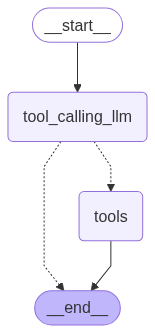

In [112]:
builder=StateGraph(State)

builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

graph = builder.compile()

graph

In [113]:
response = graph.invoke({"messages":"What is the recent AI news"})

In [114]:
response["messages"][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.reuters.com/technology/artificial-intelligence/", "title": "Artificial Intelligence - AI News - Reuters", "content": "Robots spar, play Mahjong at China\'s AI conference · New robotic dog aims to tackle all-terrain environment · Samsung shares jump on news of $16.5 bln Tesla chips", "score": 0.6899958, "raw_content": null}, {"url": "https://www.economist.com/international/2025/07/29/how-spy-agencies-are-experimenting-with-the-newest-ai-models", "title": "How spy agencies are experimenting with the newest AI models", "content": "ON THE SAME day as Donald Trump\'s inauguration as president DeepSeek, a Chinese company, released a world-class large language model (LLM).", "score": 0.44999737, "raw_content": null}], "response_time": 1.37}'

In [115]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (q5fm7g0bq)
 Call ID: q5fm7g0bq
  Args:
    query: recent AI news
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.reuters.com/technology/artificial-intelligence/", "title": "Artificial Intelligence - AI News - Reuters", "content": "Robots spar, play Mahjong at China's AI conference · New robotic dog aims to tackle all-terrain environment · Samsung shares jump on news of $16.5 bln Tesla chips", "score": 0.6899958, "raw_content": null}, {"url": "https://www.economist.com/international/2025/07/29/how-spy-agencies-are-experimenting-with-the-newest-ai-models", "title": "

In [116]:
response = graph.invoke({"messages":"what is 3 multiply by 3"})

In [117]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is 3 multiply by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (0722fhwd3)
 Call ID: 0722fhwd3
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


**ReAct Agent Architecture**

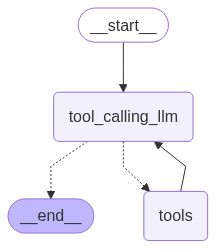

In [118]:
builder=StateGraph(State)

builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

graph

In [119]:
response = graph.invoke({"messages":"what is recent ai news and what is 3 multiply by 3"})

In [120]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is recent ai news and what is 3 multiply by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (sx6nvh3ek)
 Call ID: sx6nvh3ek
  Args:
    query: recent AI news
    time_range: day
    topic: news
  multiply (3gqkv3rr4)
 Call ID: 3gqkv3rr4
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://macholevante.com/ai-stock-frenzy-record-highs-bold-bets-and-backlash-in-late-july-2025/", "title": "AI Stock Frenzy: Record Highs, Bold Bets, and Backlash in Late July 2025 - Macholevante", "score": 0.7011614, "published_date": "Wed, 30 Jul 2025 09:10:35 GMT", "content": "In a headline announcement, leading AI chipmakers (including Huawei, Biren, Enflame, and Moore T

**Adding Memory in Agentic Graph**

In [121]:
memory = MemorySaver()

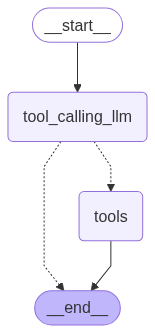

In [122]:
builder=StateGraph(State)

builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

graph = builder.compile(checkpointer=memory)

graph

In [124]:
config = {"configurable":{"thread_id":"1"}}
response = graph.invoke({"messages":"Hi my name is Musharraf"}, config=config)
response

{'messages': [HumanMessage(content='Hi my name is Musharraf', additional_kwargs={}, response_metadata={}, id='8dd0baac-bcb7-4700-9cab-064108bd9100'),
  AIMessage(content="Hello Musharraf, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 1856, 'total_tokens': 1884, 'completion_time': 0.095023989, 'prompt_time': 0.108093411, 'queue_time': 0.05326451800000001, 'total_time': 0.2031174}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--2f5f3a2c-289d-489a-9859-0e74b05f26e6-0', usage_metadata={'input_tokens': 1856, 'output_tokens': 28, 'total_tokens': 1884})]}

In [127]:
config = {"configurable":{"thread_id":"1"}}
response = graph.invoke({"messages":"Hey! do you remember my name"}, config=config)
response['messages'][-1].content

'Your name is Musharraf.'

**Streaming**

In [128]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [129]:
def superbot(state: State):
    return {"messages":[llm.invoke(state["messages"])]}

In [132]:
graph = StateGraph(State)

graph.add_node('superbot', superbot)


graph.add_edge(START, "superbot")
graph.add_edge("superbot", END)

graph_builder = graph.compile(checkpointer=memory)


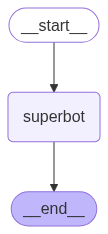

In [133]:
graph_builder

In [134]:
config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({"messages": "My name is Musharraf Hamraz and I llike Cricket"}, config=config)

{'messages': [HumanMessage(content='My name is Musharraf Hamraz and I llike Cricket', additional_kwargs={}, response_metadata={}, id='ea5b6273-6b94-4c3e-97ae-8d2316ad016d'),
  AIMessage(content="Nice to meet you, Musharraf Hamraz. Cricket is a fantastic sport, and I'm sure you must be excited about the thrill and strategy involved in the game. Which team or player is your favorite? Are you a fan of international cricket, or do you follow any specific domestic leagues, such as the IPL or PSL?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 48, 'total_tokens': 117, 'completion_time': 0.230445427, 'prompt_time': 0.002122166, 'queue_time': 0.052901364, 'total_time': 0.232567593}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--9f6ab64a-6b5d-43e0-bbeb-cdec4322bd86-0', usage_metadata={'input_tokens': 48, 'output_tokens': 69, 't

In [135]:
config = {"configurable": {"thread_id": "1"}}

for chunk in graph_builder.stream({"messages": "My name is Musharraf Hamraz and I llike Cricket"}, config=config, stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="Nice to meet you, Musharraf Hamraz! It's great that you like cricket. Cricket is an exciting sport with a huge following worldwide. Are you a fan of a particular cricket team or player? Do you have a favorite format of the game, such as Test matches, One-Day Internationals (ODIs), or Twenty20 (T20) cricket?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 139, 'total_tokens': 215, 'completion_time': 0.223892641, 'prompt_time': 0.007037141, 'queue_time': 0.008689903999999998, 'total_time': 0.230929782}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--6b71b406-e7a3-4d4f-8ee9-436e2d781e4d-0', usage_metadata={'input_tokens': 139, 'output_tokens': 76, 'total_tokens': 215})]}}


In [144]:
config = {"configurable": {"thread_id": "6"}}

for chunk in graph_builder.astream_events({"messages": "My name is Musharraf Hamraz and I llike Cricket"}, config=config, stream_mode="value"):
    print(chunk)

TypeError: 'async_generator' object is not iterable